# Trabalho prático da disciplina SCC0230 - Inteligência Artificial
### Orientadora: profª Draª Solange Oliveira Rezende

### Arthur Hiratsuka Rezende - 13687108
### Caio Assumpção Rezzadori - 11810481
### Gustavo
### João


In [1]:
import funcoes_busca as busca
import Experiment
import Interface

C:\Users\arthu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\arthu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\arthu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
user_interface = Interface.UserInterface()

In [3]:
user_interface.menu_user(figsize = (15,10), node_size=200, font_size=12)

Programa abortado!


In [4]:
caminho = busca.a_estrela(user_interface.G, 'SUZANO-11', 'LUZ-7', user_interface.df)
caminho

['SUZANO-11',
 'CALMON VIANA-11',
 'POA-11',
 'FERRAZ DE VASCONCELOS-11',
 'ANTONIO GIANETTI NETO-11',
 'GUAIANASES-11',
 'JOSE BONIFACIO-11',
 'DOM BOSCO-11',
 'CORINTHIANS ITAQUERA-11',
 'TATUAPE-11',
 'BRAS-11',
 'BRAS-7',
 'LUZ-7']

In [9]:
teste = Experiment.NewExperiment(Graph= user_interface.G, Dataframe = user_interface.df)
teste.run_experiment(n_exp=2500, n_rep=4)

df_obs = teste.df_result
df_obs.describe()

Tempo total do experimento: 2074.843911409378s


,len_AStar,dist_AStar,time_AStar,len_dfs,dist_dfs,time_dfs,len_djk,dist_djk,time_djk,len_hrt,...,delta_dist,delta_timeHeur,delta_lenHeur,delta_distHeur,delta_timeInfo,delta_lenInfo,delta_distInfo,delta_timeNao,delta_lenNao,delta_distNao
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.0,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,15.705200,28.212003,0.077741,28.293200,56.932558,0.000588,15.660800,28.206702,0.000517,15.705200,...,-28.720555,-0.003454,0.0,-0.000023,0.031045,-1.734800,-3.356620,0.000071,12.632400,28.725856
std,7.650157,17.141309,0.055036,16.076051,32.355314,0.000489,7.587356,17.136783,0.000403,7.650157,...,28.297902,0.012946,0.0,0.000799,0.038297,4.016133,5.642615,0.000573,14.065148,28.293175
min,1.000000,0.000000,0.000004,1.000000,0.000000,0.000002,1.000000,0.000000,0.000002,1.000000,...,-119.126333,-0.155824,0.0,-0.028242,-0.138704,-25.000000,-47.249268,-0.007689,-9.000000,0.000000
25%,10.000000,15.260119,0.036461,15.000000,31.806774,0.000178,10.000000,15.260119,0.000240,10.000000,...,-48.634402,-0.006429,0.0,0.000000,0.004684,-3.000000,-4.731948,-0.000272,0.000000,3.361575
50%,15.000000,24.944251,0.067104,26.000000,53.135242,0.000463,15.000000,24.944251,0.000477,15.000000,...,-19.637528,-0.002533,0.0,0.000000,0.021373,0.000000,-0.037336,-0.000023,8.000000,19.637528
75%,21.000000,38.242517,0.107234,41.000000,81.937498,0.000919,21.000000,38.242517,0.000736,21.000000,...,-3.338988,-0.000252,0.0,0.000000,0.048510,0.000000,0.000000,0.000443,21.000000,48.634402
max,40.000000,95.515101,0.537528,72.000000,149.385303,0.004214,40.000000,95.515101,0.008177,40.000000,...,0.000000,0.202893,0.0,0.000000,0.388652,11.000000,1.000000,0.002710,56.000000,119.126333


In [5]:
len(df_obs.loc[df_obs['delta_dist']==0])/len(df_obs), df_obs["time_AStar"].max()/df_obs["time_dfs"].max()

(0.2, 110.14917510042714)

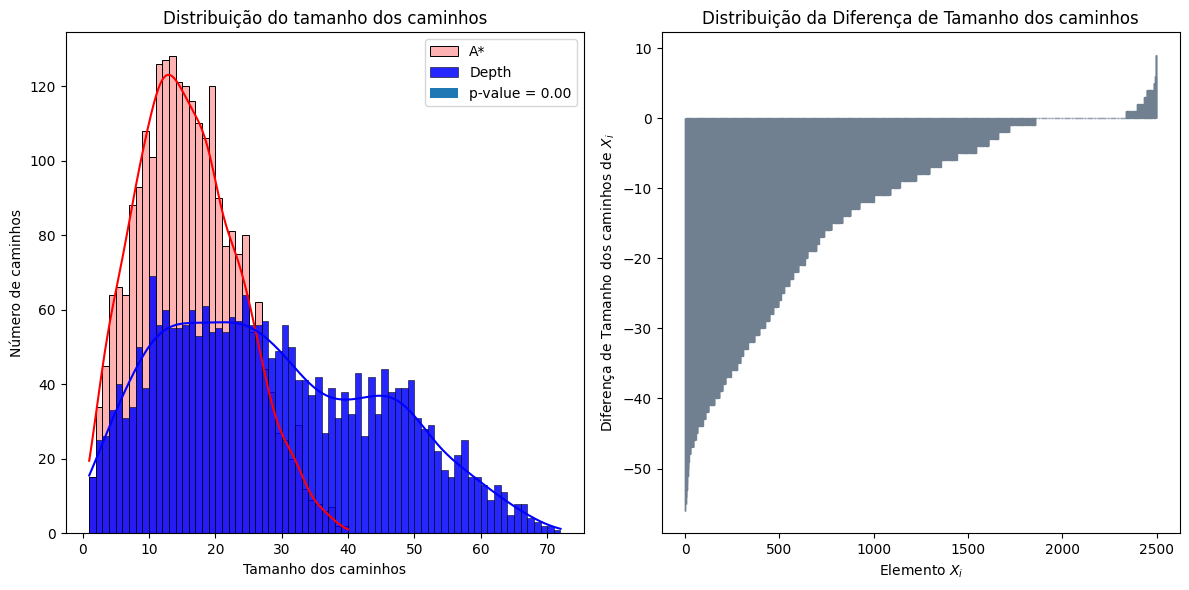

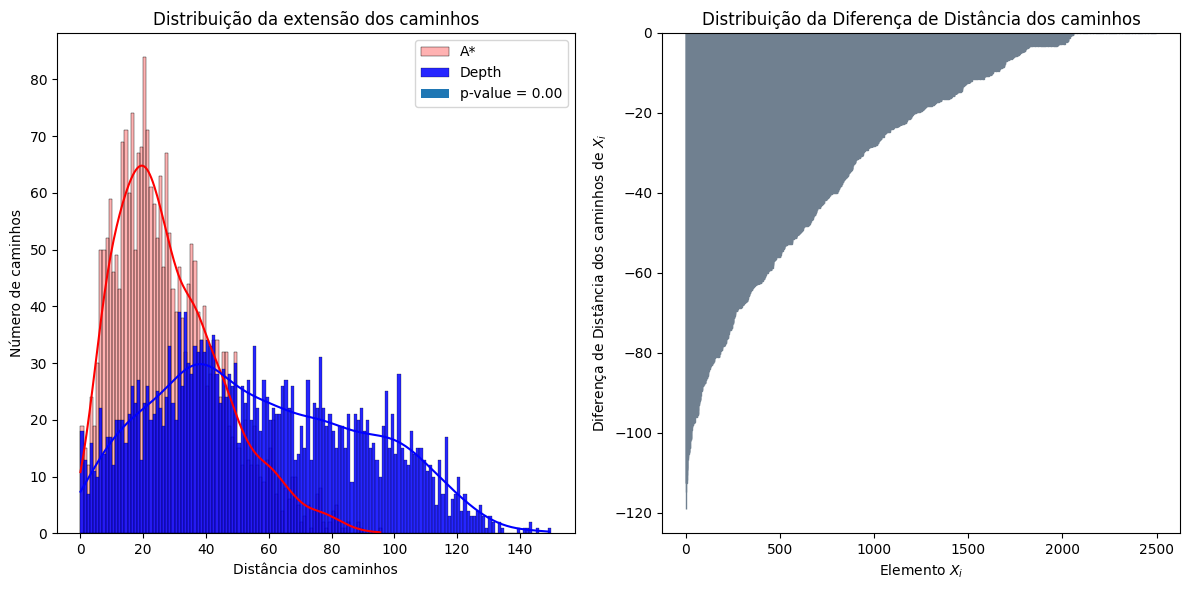

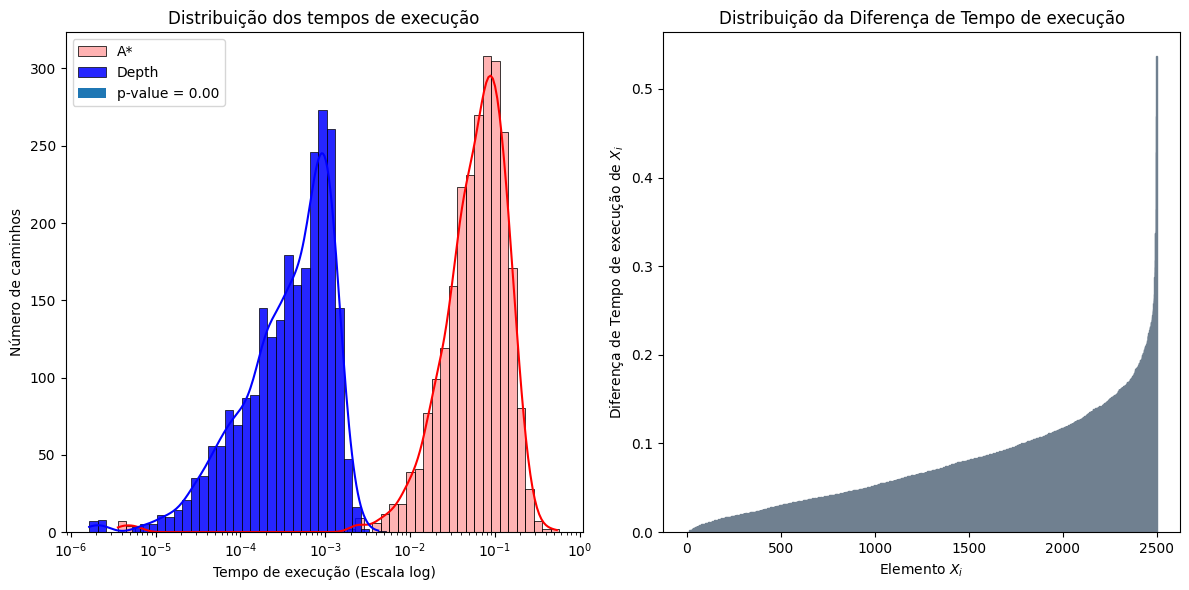

In [10]:
lista_prefixo = ["len_", "dist_", "time_"]
lista_sufixo = ["AStar", "dfs"]

for idx, prefixo in enumerate(lista_prefixo): 
    Experiment.plot_distrib_present(df_obs, prefixo+lista_sufixo[0], prefixo+lista_sufixo[1], idx)

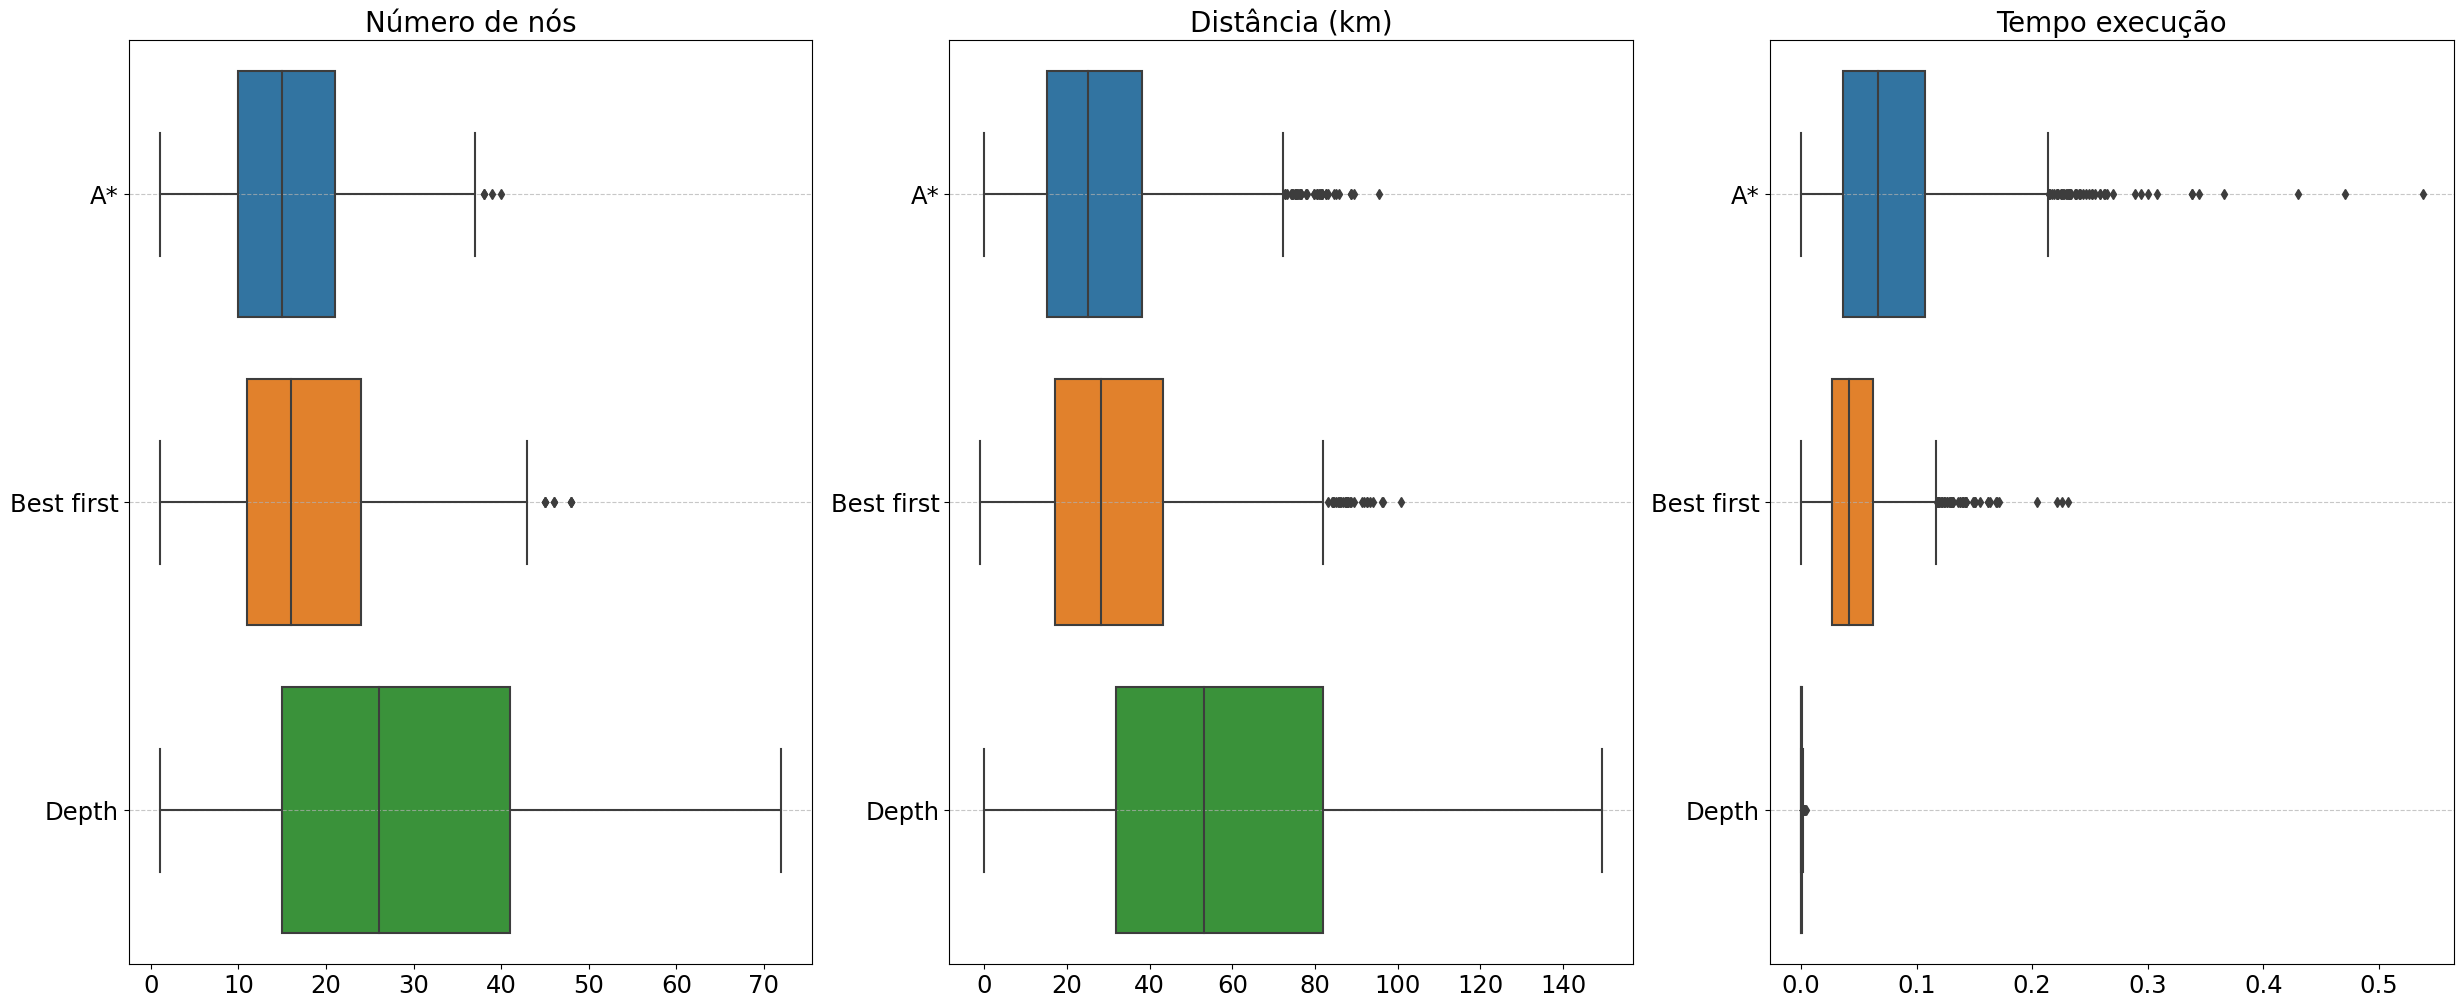

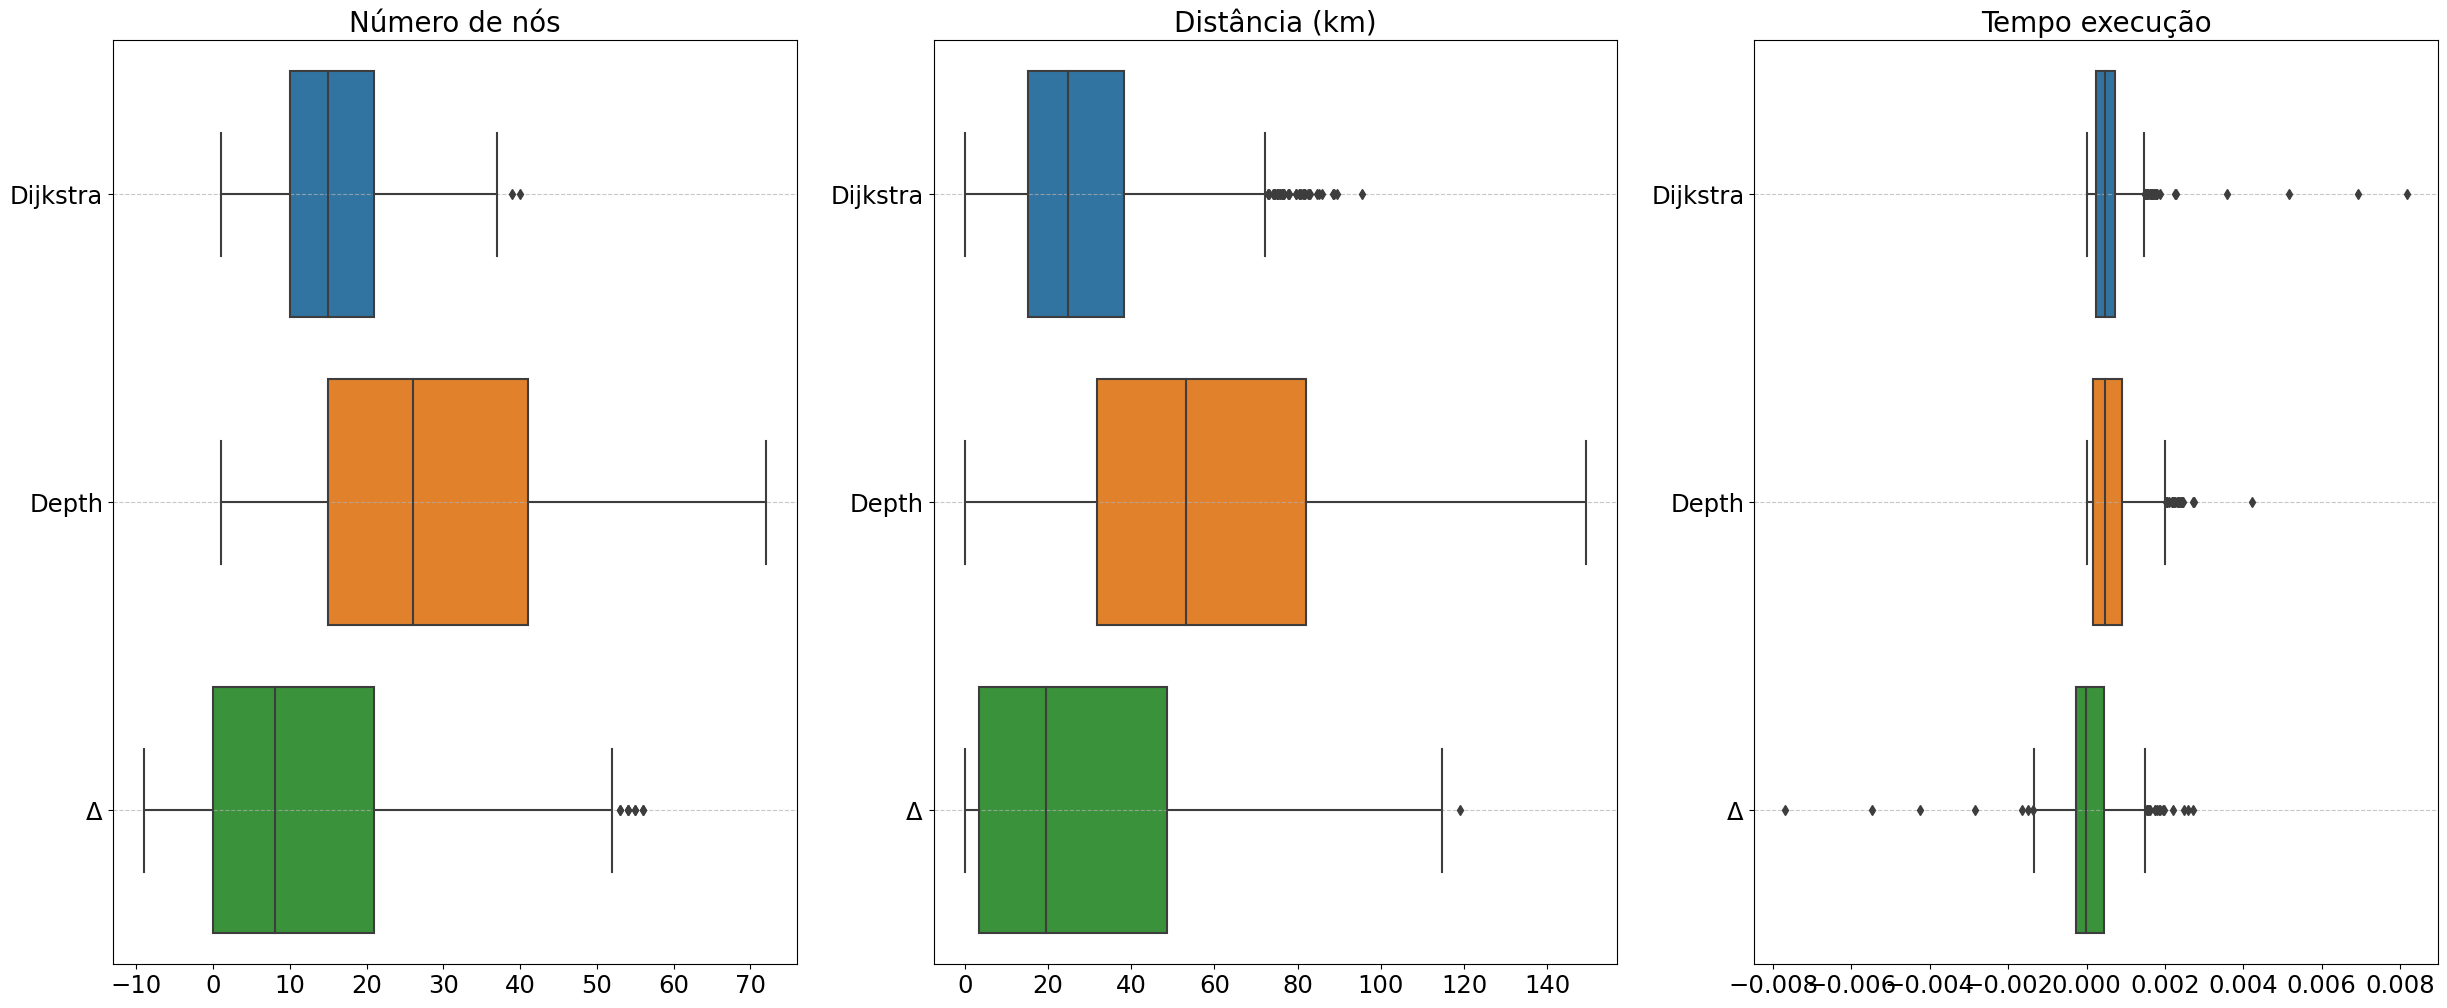

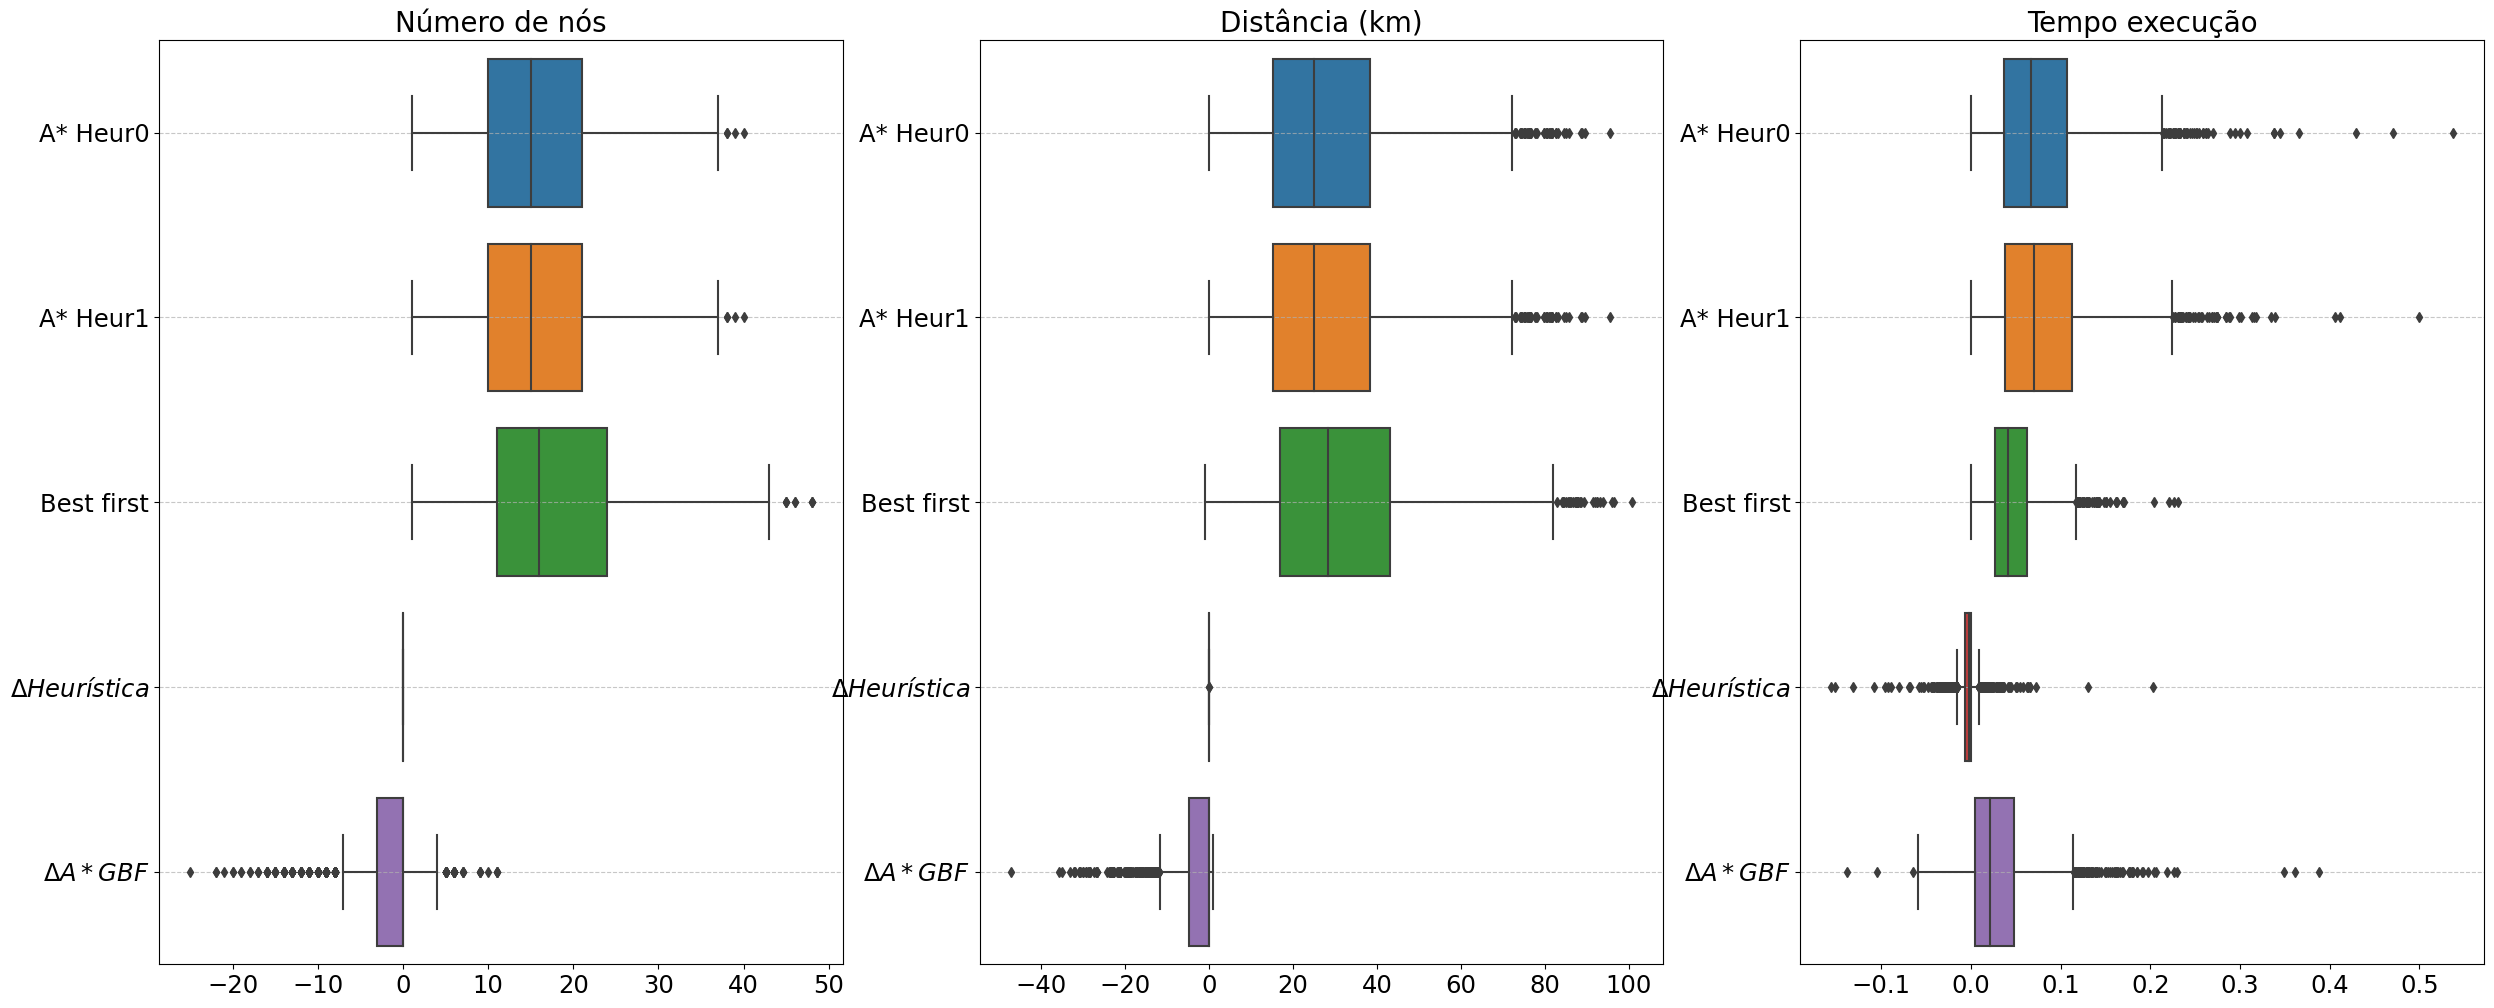

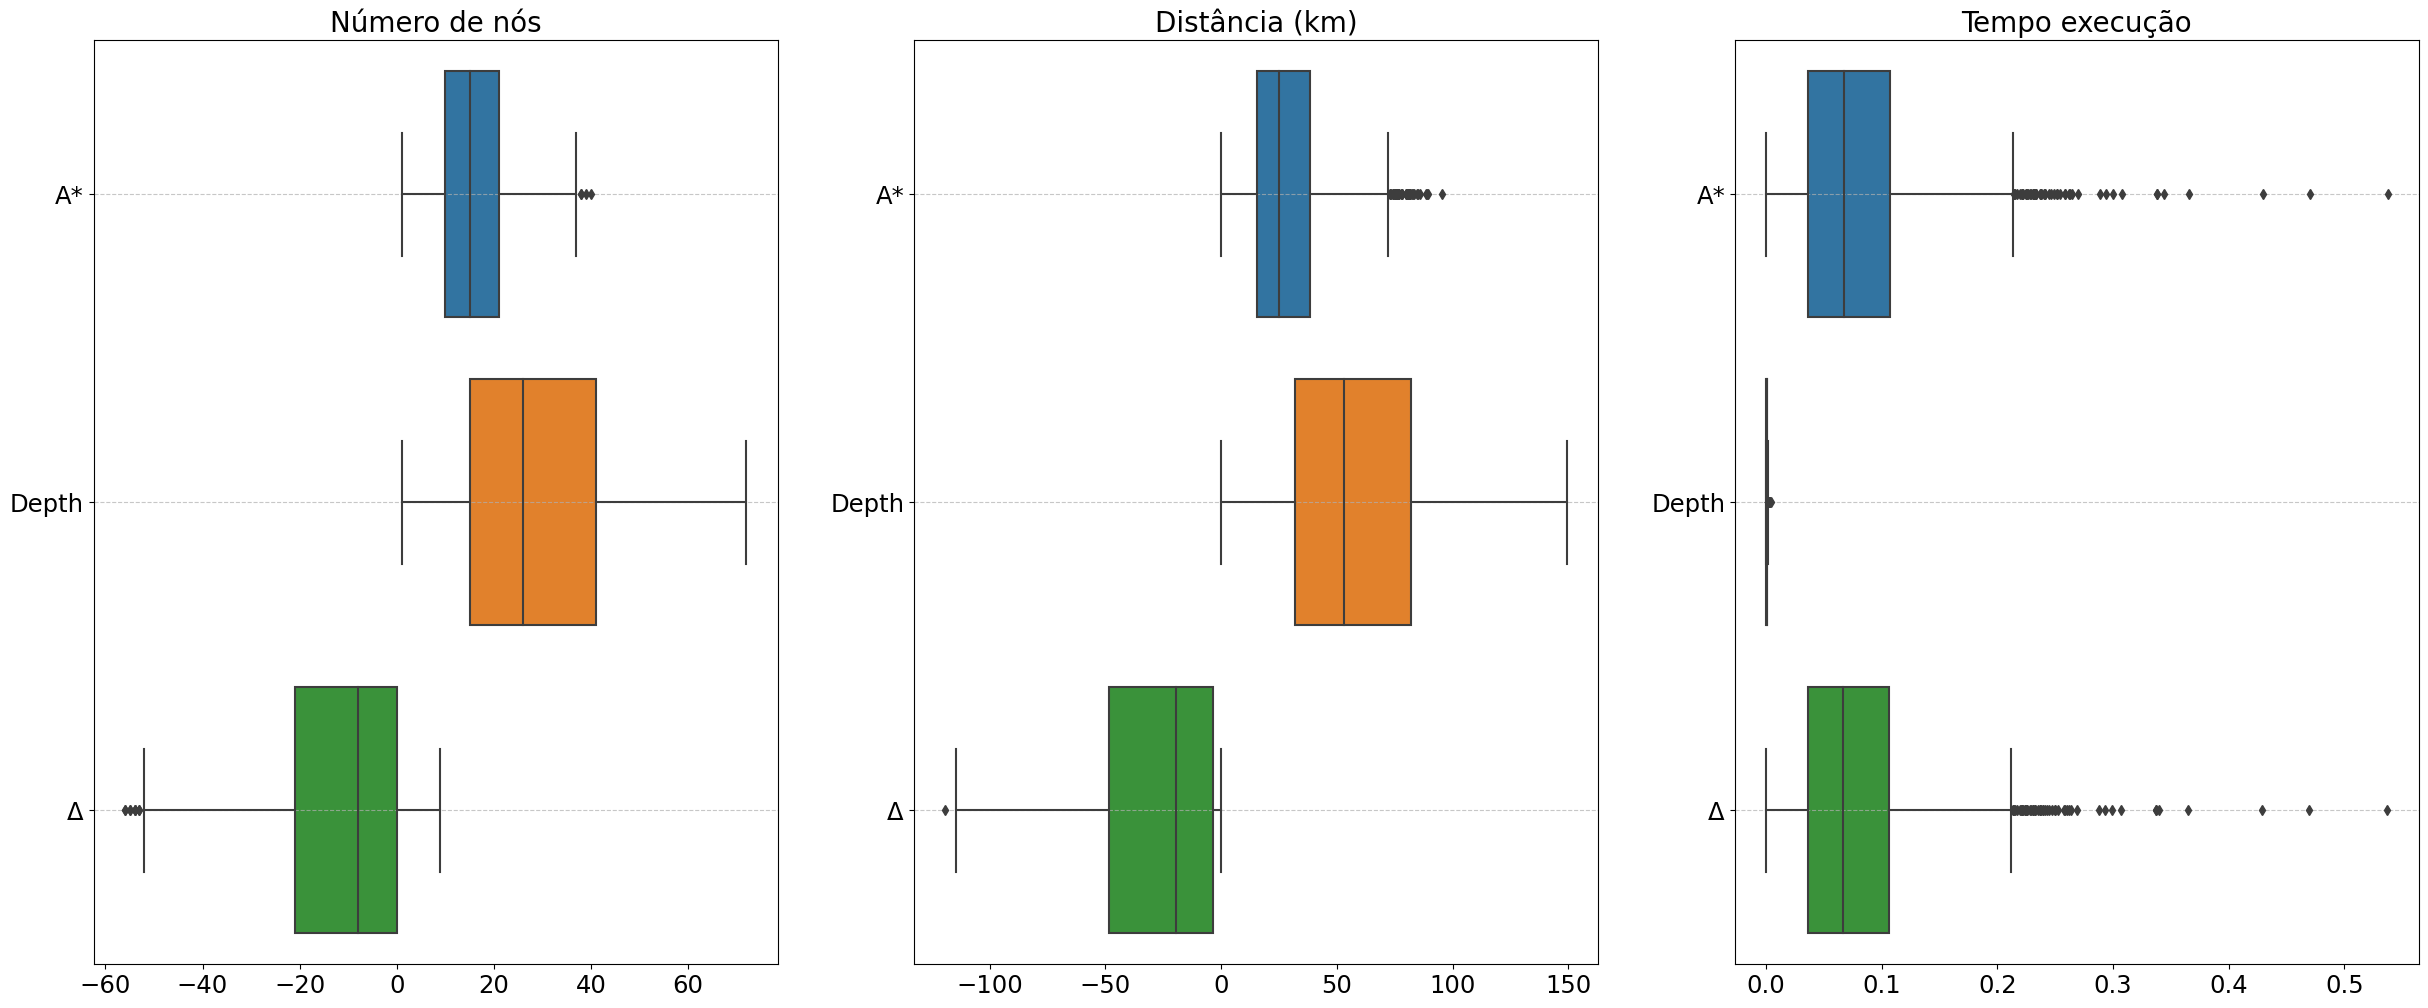

In [11]:
Experiment.plot_boxplots(df_obs)